 # Medical Cost Personal Datasets

https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download

 ## 1. Data upload and first study

In [57]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import optuna
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
# Data upload
df = pd.read_csv('/Users/macbook/Desktop/Yandex Mashine Learning/Kaggle/Insurance/insurance.csv')

In [5]:
# First study
display(df.info())
display(df.head(10))
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [9]:
# Check duplicates
df.duplicated().sum()

1

In [11]:
# Delete duplicate
df.drop_duplicates(inplace=True)

In [13]:
# Check other duplicate
object_columns = [col for col in df.select_dtypes(include=['object']).columns if col not in ['DateCrawled', 'DateCreated', 'LastSeen']]



for col in object_columns:
    print(df[col].value_counts())
    print()

sex
male      675
female    662
Name: count, dtype: int64

smoker
no     1063
yes     274
Name: count, dtype: int64

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64



 ## 2. Analysis of data

In [16]:
# Building histogram
plt.figure(figsize=(100, 100)) # size's matrix of histogram
df_describe = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']] # choice all features
num_cols = 2 # Amount of columns
num_rows = (len(df_describe.columns) + num_cols - 1) // num_cols # Amount of ranges
total_plots = num_cols * num_rows # Size of matrix

def count_bin(col): # Function for a return of amount of bins
    return len(df_describe[col].unique()) if len(df_describe[col].unique())<10 else 15

# Using cycle we create a histogram of distribution for every column
for i, col in enumerate(df_describe.columns):
    plt.rcParams.update({'font.size': 50})  # Setting the size of type for title 
    plt.rcParams.update({'axes.labelsize': 50})  # Setting the size of type for axis 
    plt.subplot(num_rows, num_cols, i+1) # Choice histogram for "i" in matrix
    plt.hist(df_describe[col], bins=count_bin(col)) # Building histogram for every column
    plt.title(col) # Assignment title for every column
    plt.xlabel('Значение')
    plt.ylabel('Частота')

plt.tight_layout() # Starting the function for automatic regulation of elemnts
plt.show()

 #### Build box-plots for every numerical columns

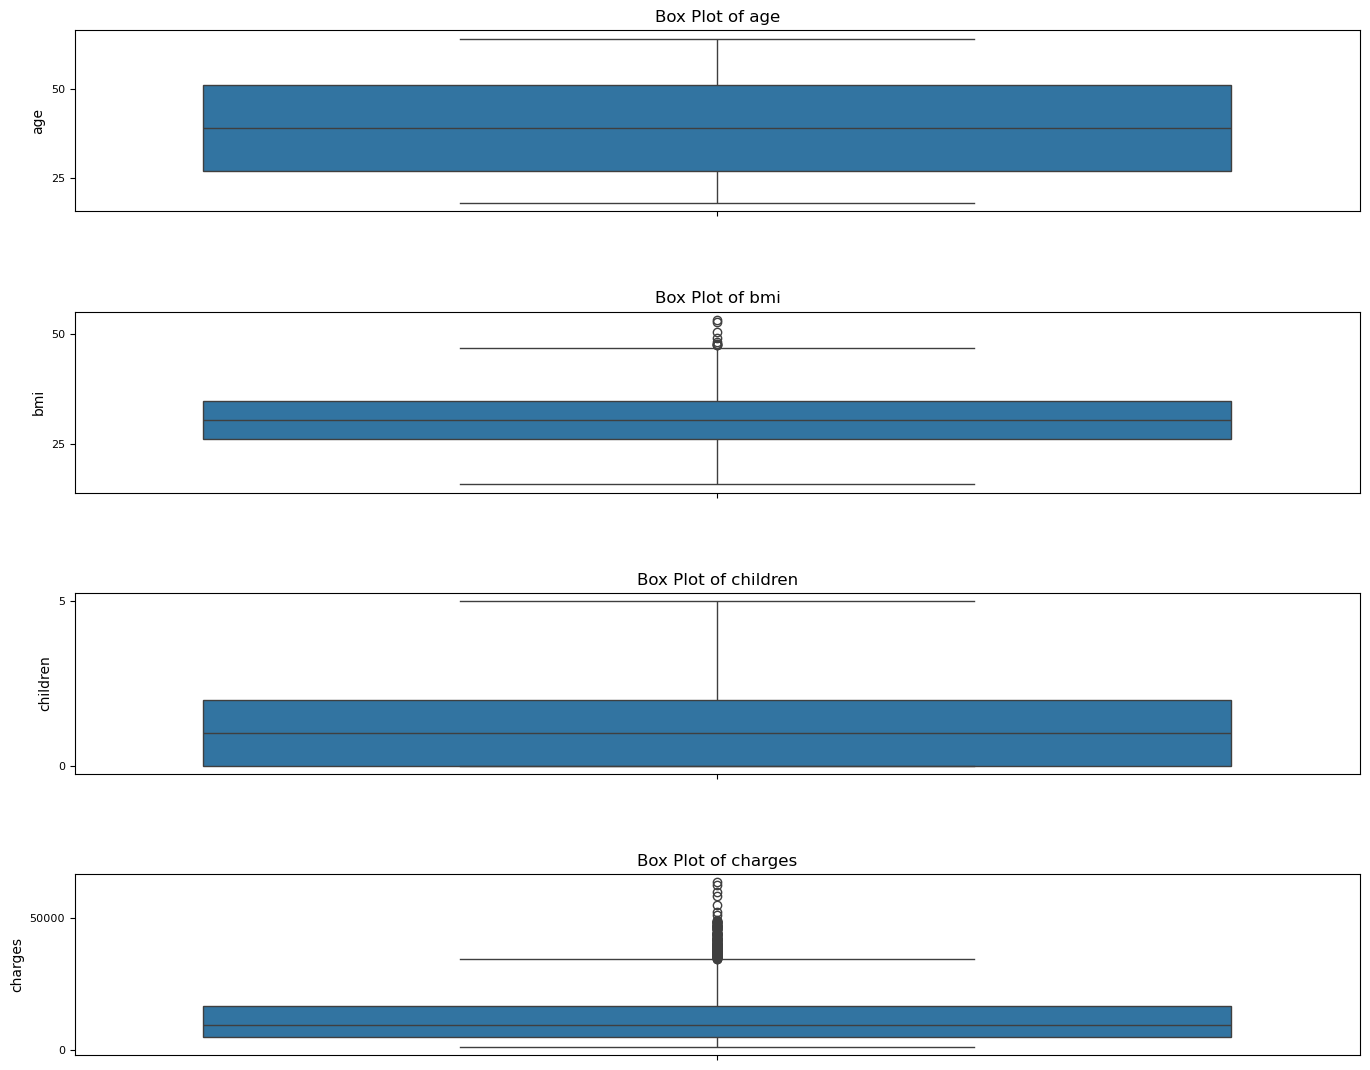

In [18]:
# Создание боксплотов для каждой числовой характеристики
numerical_features = df.select_dtypes(include=['number'])

# Определяем размер фигуры один раз
plt.figure(figsize=(15, 12))

# Создаем подграфики для каждого числового признака
for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features.columns), 1, i + 1)  # Создаем подграфик
    sns.boxplot(data=df, y=feature)
    plt.title(f'Box Plot of {feature}', fontsize=12)  # Размер шрифта заголовка
    plt.ylabel(feature, fontsize=10)  # Размер шрифта метки оси Y
    plt.xlabel('')  # Убираем метку оси X, если она не нужна
    
    # Увеличиваем размер шрифта меток на осях
    plt.xticks(fontsize=8)  # Размер шрифта меток на оси X
    plt.yticks(fontsize=8)  # Размер шрифта меток на оси Y

plt.tight_layout()  # Автоматически подгоняет подграфики
plt.show()

In [38]:
# Replace male by 1 and female by 1 in column sex
df['sex'] = df['sex'].replace({'male': 1, 'female': 0})

# Replace yes by 1 and no by 1 in column smoker
df['smoker'] = df['smoker'].replace({'yes': 1, 'no': 0})

# Replace yes by 1 and no by 1 in column smoker
df['region'] = df['region'].replace({'southeast': 0, 'southwest': 1, 'northwest':2, 'northeast':3})

/var/folders/b4/mc0v_4c562xfny9p49bm920h0000gn/T/ipykernel_26273/2015504239.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['region'] = df['region'].replace({'southeast': 0, 'southwest': 1, 'northwest':2, 'northeast':3})


 #### Build a matrix of dependences for target

<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
/var/folders/b4/mc0v_4c562xfny9p49bm920h0000gn/T/ipykernel_26273/352057533.py:9: SyntaxWarning: invalid escape sequence '\p'
  title='Корреляция $\phi_k$',


interval columns not set, guessing: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


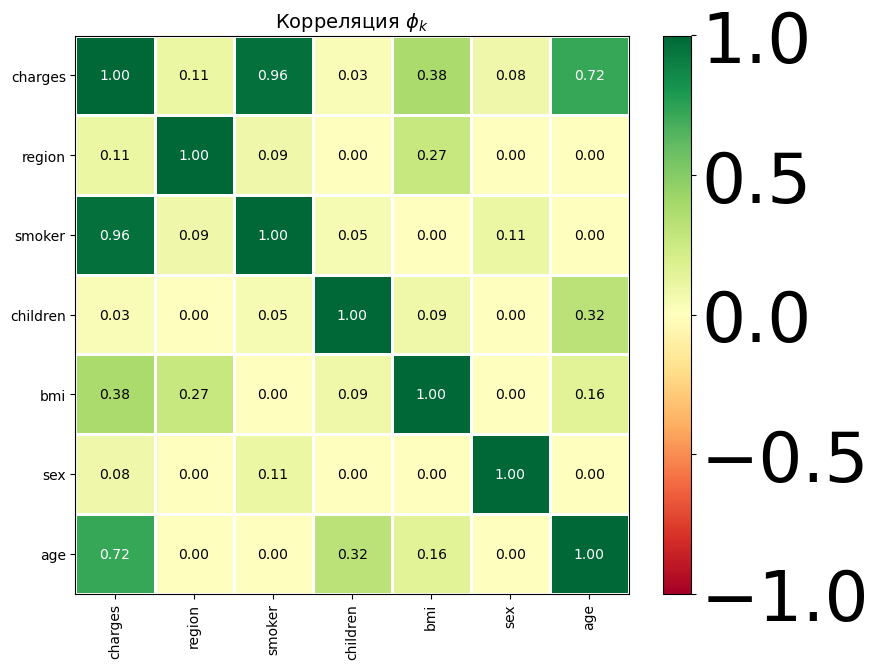

In [41]:
# Receive a correlation
phik_corr = df.phik_matrix()

# Build   
plot_correlation_matrix(
    phik_corr.values,
    x_labels=phik_corr.columns,
    y_labels=phik_corr.index,
    title='Корреляция $\phi_k$',
    identity_layout=True,
    figsize=(10, 8)
)


 ### PCA

In [43]:
def feature_importance_with_lin(df, target_variable):
    # Remove the target variable and 'date' column
    X = df.drop([target_variable], axis=1)
    y = df[target_variable]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create and train a linear regression model
    model = LinearRegression()
    model.fit(X_scaled, y)

    # Get the model coefficients
    importance = model.coef_

    # Create a DataFrame to store feature names and their corresponding importance scores
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    })

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    return importance_df

In [45]:
def feature_importance_with_random_forest(df, target_variable):
    # Remove the target variable and 'date' column
    X = df.drop([target_variable], axis=1)
    y = df[target_variable]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a random forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)

    # Get feature importances
    importance = model.feature_importances_

    # Create a DataFrame to store feature names and their corresponding importance scores
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    })

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    return importance_df

In [47]:
def feature_importance_pca(df, columns_to_drop):
    # Drop specified columns
    X = df.drop(columns=columns_to_drop)

    # Initialize the StandardScaler to standardize the features
    scaler = StandardScaler()

    # Fit the scaler to the data and transform it to standardized values
    scaled_data = scaler.fit_transform(X)

    # Initialize PCA (Principal Component Analysis)
    pca = PCA()

    # Fit PCA on the scaled data to compute principal components
    pca.fit(scaled_data)

    # Get the explained variance ratio for each principal component
    explained_variance = pca.explained_variance_ratio_

    # Get the components (loadings) of PCA
    components = pca.components_

    # Calculate feature importance as the sum of absolute values of components multiplied by explained variance
    importance = abs(components).sum(axis=0) * explained_variance

    # Create a DataFrame to hold feature names and their corresponding importance scores
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    })

    return importance_df

In [49]:
importance_lin = feature_importance_with_lin(df, 'charges')
importance_lin

,Feature,Importance
4,smoker,9631.498850
0,age,3602.754126
2,bmi,2077.469633
3,children,569.564579
5,region,418.402956
1,sex,-64.712364


In [51]:
importance_forest = feature_importance_with_random_forest(df, 'charges')
importance_forest

,Feature,Importance
4,smoker,0.600777
2,bmi,0.215870
0,age,0.136667
3,children,0.023121
5,region,0.016528
1,sex,0.007037


In [59]:
importance_pca = feature_importance_pca(df, ['charges'])
importance_pca

,Feature,Importance
0,age,0.492011
1,sex,0.390905
2,bmi,0.291371
3,children,0.250205
4,smoker,0.286517
5,region,0.231469


 #### Column 'age' 

In [72]:
df.age.describe()

count    1337.000000
mean       39.222139
std        14.044333
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

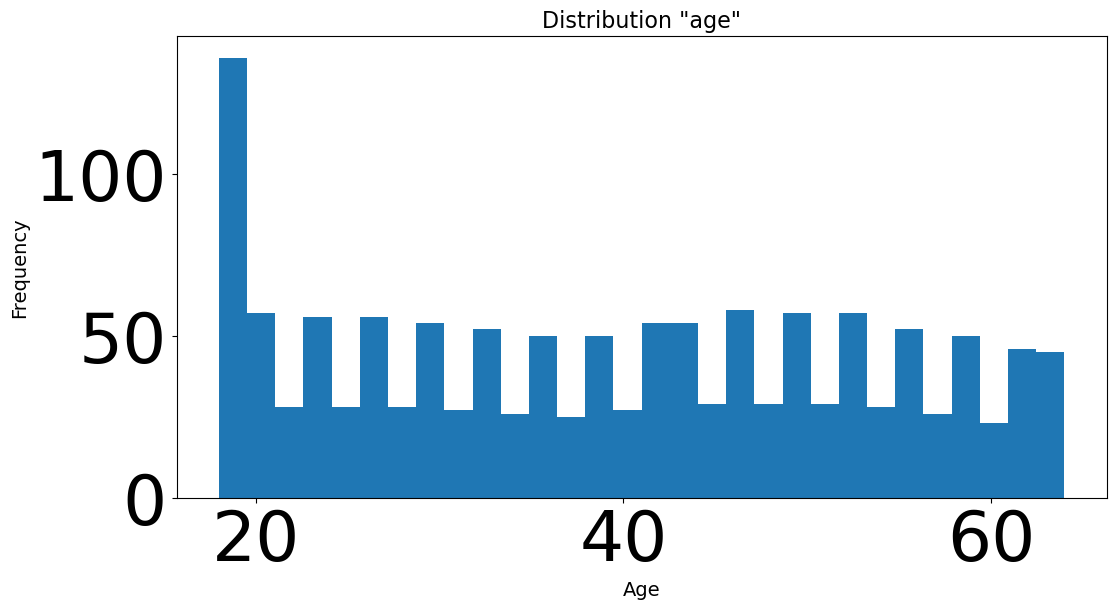

In [62]:
# Создание фигуры и оси
plt.figure(figsize=(12, 6))

# Построение гистограммы
plt.hist(df['age'], bins=30)

# Добавление заголовка и меток осей
plt.title('Distribution "age"', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Показать график
plt.show()

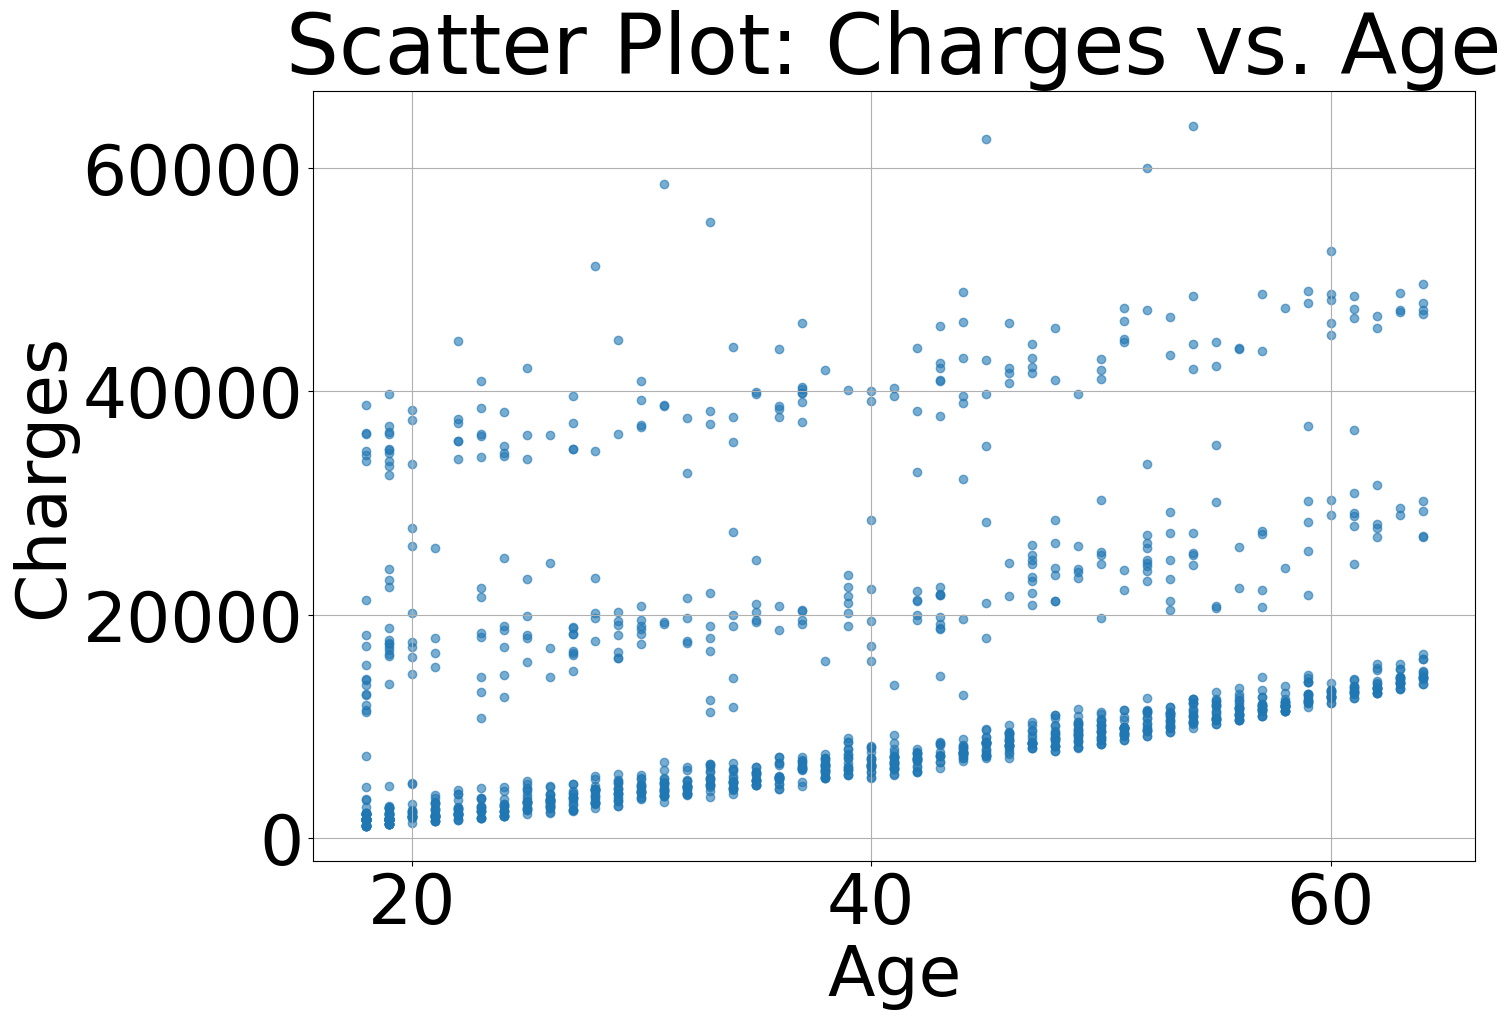

In [76]:
plt.figure(figsize=(15, 10))
plt.scatter(df['age'], df['charges'], alpha=0.6)

plt.title('Scatter Plot: Charges vs. Age')
plt.xlabel('Age')
plt.ylabel('Charges')

plt.grid(True)
plt.show()

 #### Column 'bmi'

In [79]:
df.bmi.describe()

count    1337.000000
mean       30.663452
std         6.100468
min        15.960000
25%        26.290000
50%        30.400000
75%        34.700000
max        53.130000
Name: bmi, dtype: float64

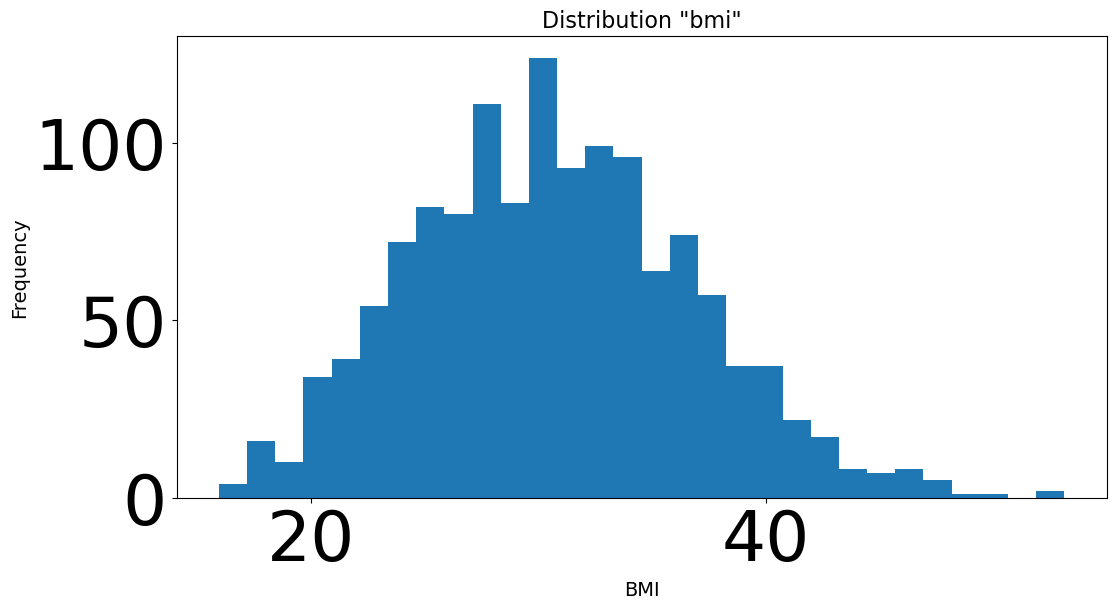

In [81]:
# Создание фигуры и оси
plt.figure(figsize=(12, 6))

# Построение гистограммы
plt.hist(df['bmi'], bins=30)

# Добавление заголовка и меток осей
plt.title('Distribution "bmi"', fontsize=16)
plt.xlabel('BMI', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Показать график
plt.show()

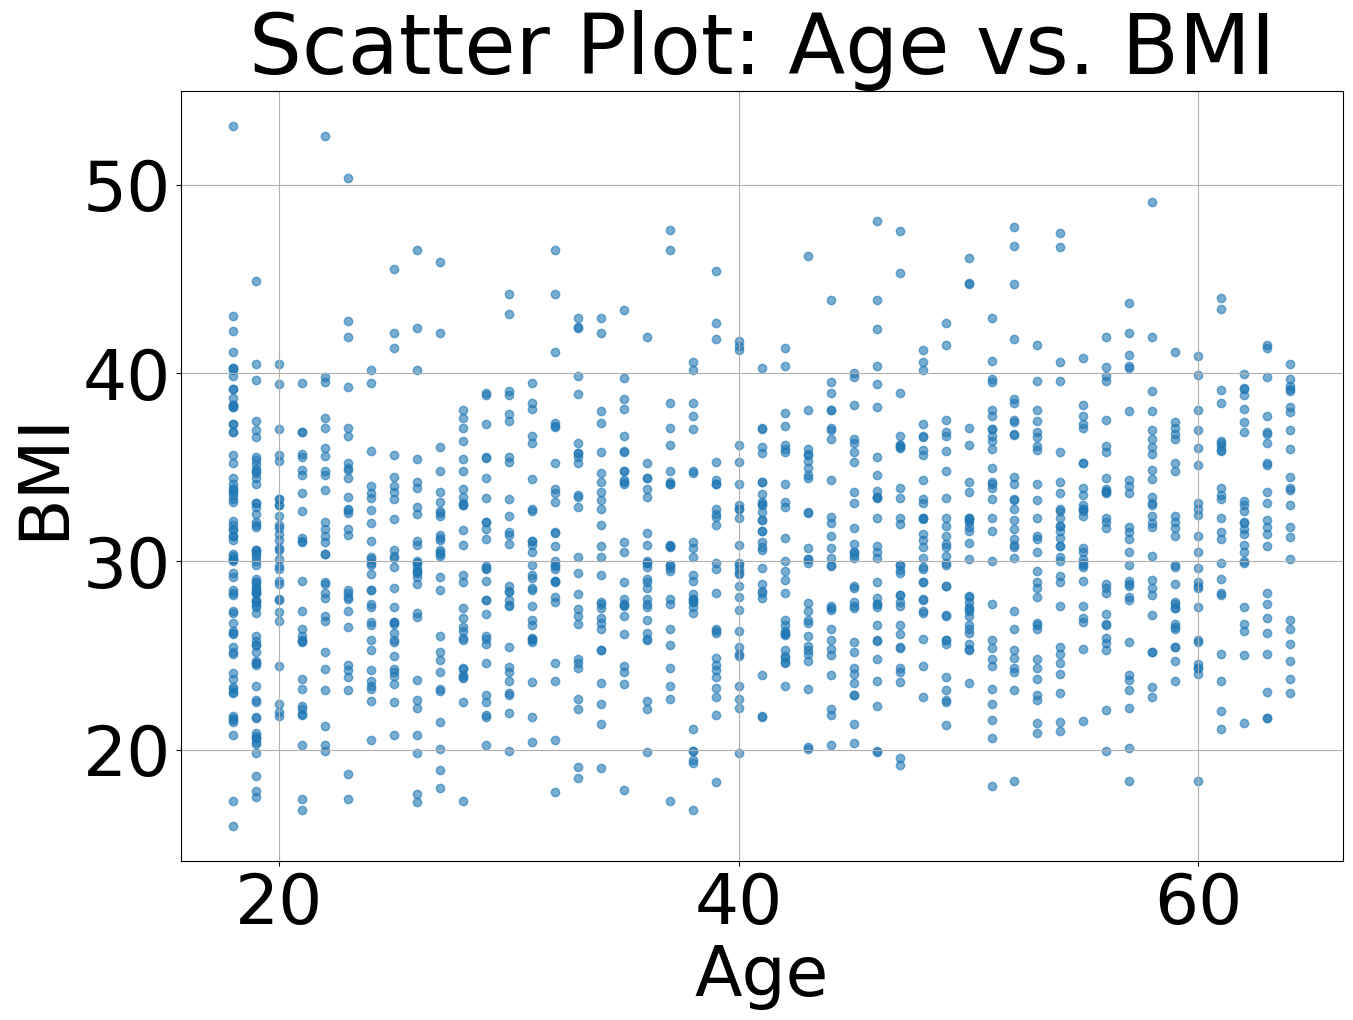

In [89]:
plt.figure(figsize=(15, 10))
plt.scatter(df['age'], df['bmi'], alpha=0.6)

plt.title('Scatter Plot: Age vs. BMI')
plt.xlabel('Age')
plt.ylabel('BMI')

plt.grid(True)
plt.show()

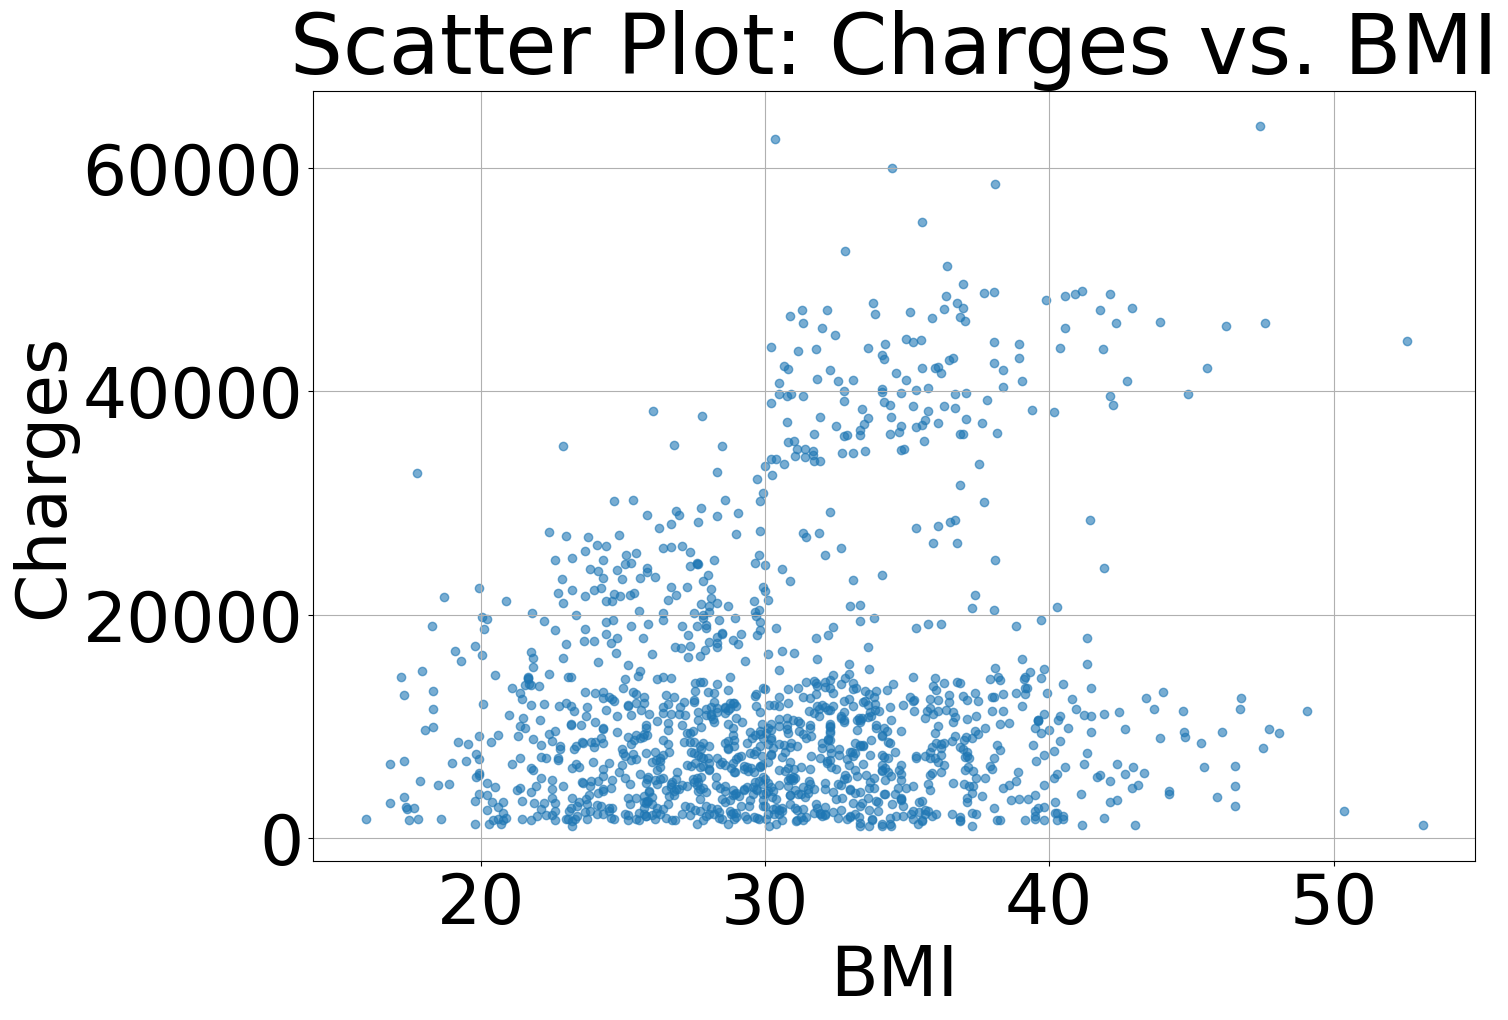

In [97]:
plt.figure(figsize=(15, 10))
plt.scatter(df['bmi'], df['charges'], alpha=0.6)

plt.title('Scatter Plot: Charges vs. BMI')
plt.xlabel('BMI')
plt.ylabel('Charges')

plt.grid(True)
plt.show()

 #### Column 'smoker'

In [100]:
df.smoker.value_counts()

smoker
0    1063
1     274
Name: count, dtype: int64

In [106]:
df.query('smoker == 1')['charges'].describe()

count      274.000000
mean     32050.231832
std      11541.547176
min      12829.455100
25%      20826.244213
50%      34456.348450
75%      41019.207275
max      63770.428010
Name: charges, dtype: float64

In [108]:
df.query('smoker == 0')['charges'].describe()

count     1063.000000
mean      8440.660307
std       5992.973800
min       1121.873900
25%       3988.883500
50%       7345.726600
75%      11363.019100
max      36910.608030
Name: charges, dtype: float64

/var/folders/b4/mc0v_4c562xfny9p49bm920h0000gn/T/ipykernel_26273/2554431432.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


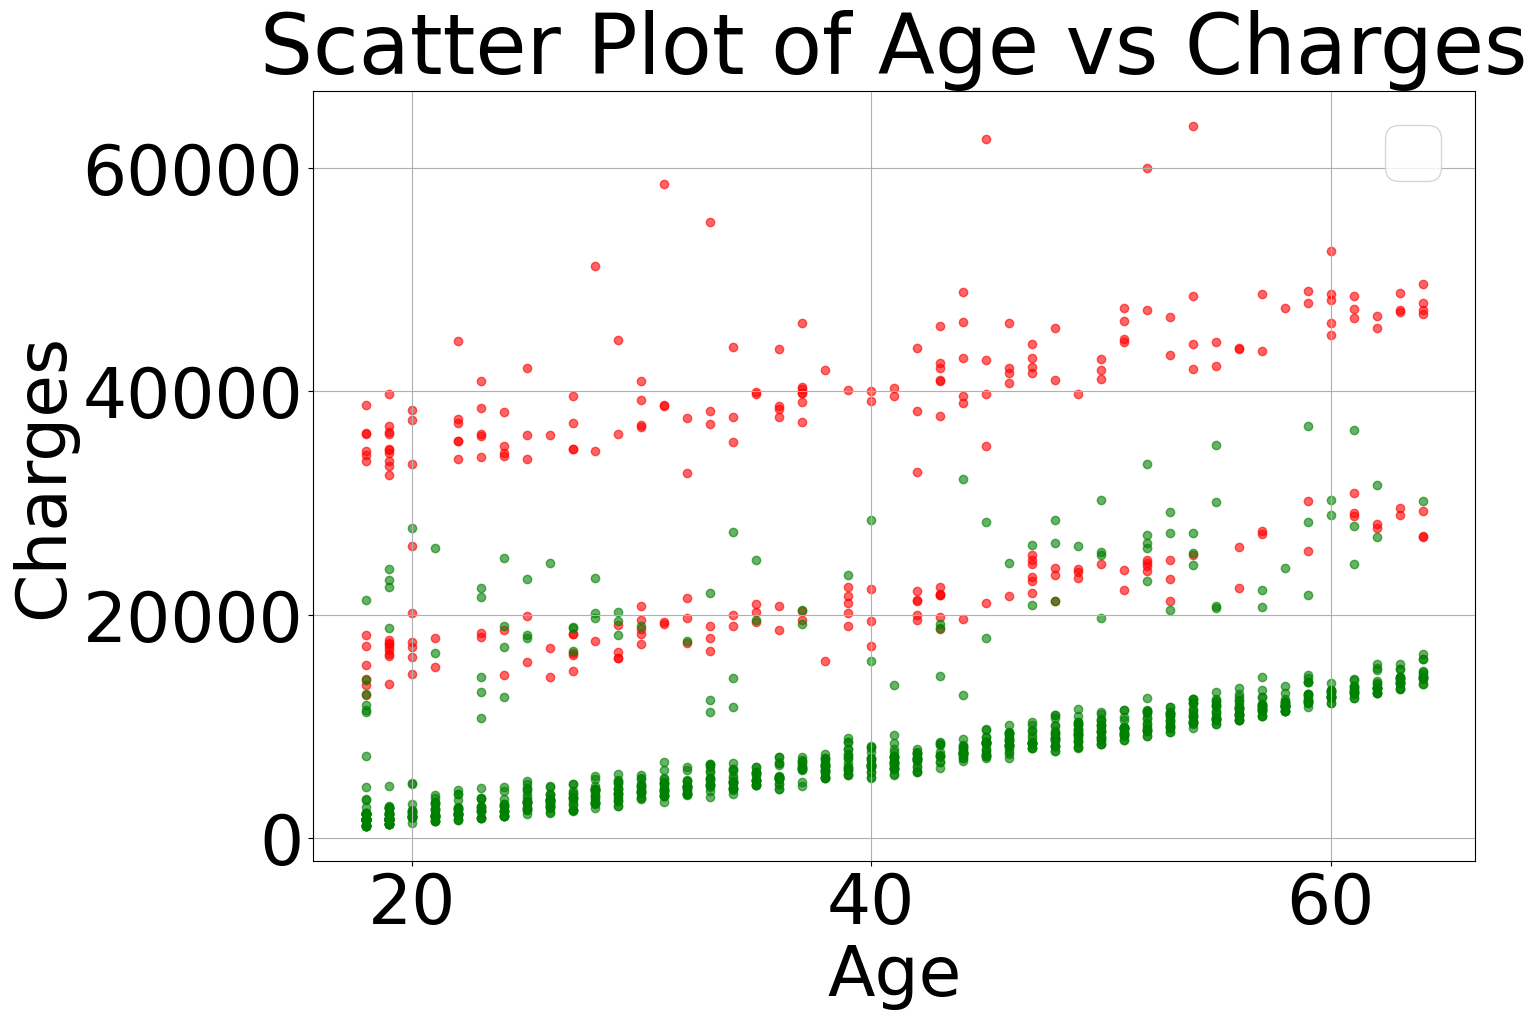

In [104]:
plt.figure(figsize=(15, 10))

# smoker = 1 (red)
plt.scatter(df[df['smoker'] == 1]['age'], df[df['smoker'] == 1]['charges'], 
            color='red',  alpha=0.6)


# smoker = 0 (green)
plt.scatter(df[df['smoker'] == 0]['age'], df[df['smoker'] == 0]['charges'], 
            color='green',  alpha=0.6)


# Настройка графика
plt.title('Scatter Plot of Age vs Charges')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend()
plt.grid(True)
plt.show()

 ## Data preparation

In [168]:
df = pd.get_dummies(df, drop_first=True)

# Select a features and target
features = df.drop(['charges'], axis=1)
target = df['charges']

# Part a data for train and test
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=12345, test_size=0.2)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)


# Check a target in train data and test data
print('Train data', target_train.shape)
print()
print('Test data', target_test.shape)

Train data (1069,)

Test data (268,)


 #### Write the function for metrics

In [141]:
def metrics(predictions, target):
    mae = mean_absolute_error(target, predictions)
    mse = mean_squared_error(target, predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(target, predictions)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'mape': mape}

 ### Train Linear Regression model

In [144]:
fit_intercepts = [True, False]
best_result = 0
linear_regres, best_fit_intercept = None, None

for fit_intercept in fit_intercepts:
    model = LinearRegression(fit_intercept=fit_intercept)
    
    scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
    result = np.mean(scores)  

    if result > best_result:
        linear_regres = model
        best_result = result
        best_fit_intercept = fit_intercept



# Train model
linear_regres.fit(features_train, target_train)

# Received predictions
predictions = linear_regres.predict(features_test)

lin_reg = metrics(predictions, target_test)


print(f'The best parameters: fit_intercept={best_fit_intercept}')
print(f'Metrics: {lin_reg}')

The best parameters: fit_intercept=True
Metrics: {'MAE': 4047.9262400592456, 'MSE': 35071975.48471167, 'RMSE': 5922.159697670409, 'mape': 0.41242404169113733}


 #### Train DecisionTree Model

In [147]:
min_samples_splits = [2, 5, 10]
best_result = 0
best_params = None
decision_tree_regressor = None

for max_depth in range(1, 16):
    for min_samples_split in min_samples_splits:
        model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)
        
        scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
        result = np.mean(scores)  

        if result > best_result:
            decision_tree_regressor = model
            best_result = result
            best_params = (max_depth, min_samples_split)

# Train model
decision_tree_regressor.fit(features_train, target_train)

# Receive predictions
predictions = decision_tree_regressor.predict(features_test)


dec_reg = metrics(predictions, target_test)

print(f'The best parameters: max_depth={best_params[0]}, min_samples_split={best_params[1]}')
print(f'Metrics: {dec_reg}')

The best parameters: max_depth=4, min_samples_split=2
Metrics: {'MAE': 2623.394062601924, 'MSE': 19708135.044324398, 'RMSE': 4439.384534406137, 'mape': 0.30006475304714586}


 #### Train Randomforest Model

In [149]:
n_estimators_options = [50, 100, 200]
max_depths = range(1, 16)
best_result = 0
best_params = None
random_forest_regressor = None

for n_estimators in n_estimators_options:
    for max_depth in max_depths:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        
        scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
        result = np.mean(scores) 

        if result > best_result:
            random_forest_regressor = model
            best_result = result
            best_params = (n_estimators, max_depth)

# Train model
random_forest_regressor.fit(features_train, target_train)

# Receive predictions
predictions = random_forest_regressor.predict(features_test)

rf_metrics = metrics(predictions, target_test)

print(f'The best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]}')
print(f'Metrics: {rf_metrics}')

The best parameters: n_estimators=200, max_depth=4
Metrics: {'MAE': 2451.274805087346, 'MSE': 17642815.16047117, 'RMSE': 4200.335124781256, 'mape': 0.2955333224738577}


 #### Train KNeighborsRegressor model

In [152]:
n_neighbors_options = [3, 5, 7, 10, 15]
weights_options = ['uniform', 'distance']
best_result = 0
best_params = None
knn_regressor = None

for n_neighbors in n_neighbors_options:
    for weights in weights_options:
        model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
        
        scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
        result = np.mean(scores)  

        if result > best_result:
            knn_regressor = model
            best_result = result
            best_params = (n_neighbors, weights)

# Train model
knn_regressor.fit(features_train, target_train)

# Receive predictions
predictions = knn_regressor.predict(features_test)

knn_metrics = metrics(predictions, target_test)

print(f'The best parameters: n_neighbors={best_params[0]}, weights={best_params[1]}')
print(f'Metrics: {knn_metrics}')

The best parameters: n_neighbors=10, weights=distance
Metrics: {'MAE': 2926.9764735908475, 'MSE': 24437629.657606274, 'RMSE': 4943.443097437886, 'mape': 0.35497958119575485}


 #### Train LGBMRegressor model

In [154]:
lgbm_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, -1]  # -1 означает отсутствие ограничения
}

best_result_lgbm = 0
best_params_lgbm = None
lgbm_regressor = None

for n_estimators in lgbm_params['n_estimators']:
    for learning_rate in lgbm_params['learning_rate']:
        for max_depth in lgbm_params['max_depth']:
            model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, verbose=-1)
            
            scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
            result = np.mean(scores)

            if result > best_result_lgbm:
                lgbm_regressor = model
                best_result_lgbm = result
                best_params_lgbm = (n_estimators, learning_rate, max_depth)

# Обучение модели
lgbm_regressor.fit(features_train, target_train)

# Получение предсказаний
predictions_lgbm = lgbm_regressor.predict(features_test)

# Вычисление метрик
lgbm_metrics = metrics(predictions_lgbm, target_test)

print(f'LGBM - The best parameters: n_estimators={best_params_lgbm[0]}, learning_rate={best_params_lgbm[1]}, max_depth={best_params_lgbm[2]}')
print(f'LGBM - Metrics: {lgbm_metrics}')

LGBM - The best parameters: n_estimators=50, learning_rate=0.1, max_depth=3
LGBM - Metrics: {'MAE': 2334.112704380113, 'MSE': 16873103.966219556, 'RMSE': 4107.688396923451, 'mape': 0.2950268514925394}


 #### Train CatBoostRegressor model

In [156]:
catboost_params = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7]
}

best_result_catboost = 0
best_params_catboost = None
catboost_regressor = None

for iterations in catboost_params['iterations']:
    for learning_rate in catboost_params['learning_rate']:
        for depth in catboost_params['depth']:
            model = CatBoostRegressor(iterations=iterations, learning_rate=learning_rate, depth=depth, verbose=0)
            
            scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
            result = np.mean(scores)

            if result > best_result_catboost:
                catboost_regressor = model
                best_result_catboost = result
                best_params_catboost = (iterations, learning_rate, depth)

# Обучение модели
catboost_regressor.fit(features_train, target_train)

# Получение предсказаний
predictions_catboost = catboost_regressor.predict(features_test)

# Вычисление метрик
catboost_metrics = metrics(predictions_catboost, target_test)

print(f'CatBoost - The best parameters: iterations={best_params_catboost[0]}, learning_rate={best_params_catboost[1]}, depth={best_params_catboost[2]}')
print(f'CatBoost - Metrics: {catboost_metrics}')

CatBoost - The best parameters: iterations=100, learning_rate=0.1, depth=3
CatBoost - Metrics: {'MAE': 2282.928133023436, 'MSE': 17308312.00642552, 'RMSE': 4160.325949541156, 'mape': 0.28086380226865154}


 #### Train MLPRegressor model

In [158]:
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 300]
}

best_result_mlp = 0
best_params_mlp = None
mlp_regressor = None

for hidden_layer_sizes in mlp_params['hidden_layer_sizes']:
    for activation in mlp_params['activation']:
        for learning_rate_init in mlp_params['learning_rate_init']:
            for max_iter in mlp_params['max_iter']:
                model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                                     activation=activation,
                                     learning_rate_init=learning_rate_init,
                                     max_iter=max_iter,
                                     random_state=42,
                                     verbose=0)
                
                scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
                result = np.mean(scores)

                if result > best_result_mlp:
                    mlp_regressor = model
                    best_result_mlp = result
                    best_params_mlp = (hidden_layer_sizes, activation, learning_rate_init, max_iter)

# Обучение модели
mlp_regressor.fit(features_train, target_train)

# Получение предсказаний
predictions_mlp = mlp_regressor.predict(features_test)

# Вычисление метрик
mlp_metrics = metrics(predictions_mlp, target_test)

print(f'MLP - The best parameters: hidden_layer_sizes={best_params_mlp[0]}, activation={best_params_mlp[1]}, learning_rate_init={best_params_mlp[2]}, max_iter={best_params_mlp[3]}')
print(f'MLP - Metrics: {mlp_metrics}')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

MLP - The best parameters: hidden_layer_sizes=(100,), activation=relu, learning_rate_init=0.1, max_iter=300
MLP - Metrics: {'MAE': 2797.7219522871465, 'MSE': 21521818.63631759, 'RMSE': 4639.161415204001, 'mape': 0.3004148004407246}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


 ## Conclusion

In [159]:
# Build a table for total

model_metrics = [lin_reg, dec_reg, rf_metrics, knn_metrics, lgbm_metrics, catboost_metrics, mlp_metrics]

total = pd.DataFrame(model_metrics, index=['LogisticRegression', 'DecisionTree', 'RandomForest', 'KNeighborsClassifier', 'LGBM', 'CatBoost', 'MLPClassifier'])
print(total.sort_values(by='mape', ascending=True))

                              MAE           MSE         RMSE      mape
CatBoost              2282.928133  1.730831e+07  4160.325950  0.280864
LGBM                  2334.112704  1.687310e+07  4107.688397  0.295027
RandomForest          2451.274805  1.764282e+07  4200.335125  0.295533
DecisionTree          2623.394063  1.970814e+07  4439.384534  0.300065
MLPClassifier         2797.721952  2.152182e+07  4639.161415  0.300415
KNeighborsClassifier  2926.976474  2.443763e+07  4943.443097  0.354980
LogisticRegression    4047.926240  3.507198e+07  5922.159698  0.412424


 ### Improving metrics

In [325]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    # Определяем диапазоны для гиперпараметров
    iterations = trial.suggest_int('iterations', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
    depth = trial.suggest_int('depth', 3, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 50)

    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        min_data_in_leaf=min_data_in_leaf,
        random_seed=42,
        verbose=0 
    )

    model.fit(features_train, target_train)
    y_pred = model.predict(features_test)  # Используем тестовую выборку
    mape = mean_absolute_percentage_error(target_test, y_pred)

    return mape  # Минимизируем MSE

# Создаем объект исследования Optuna
study = optuna.create_study(direction='minimize')  # Мы минимизируем MSE
study.optimize(objective, n_trials=30)

# Получаем лучшие параметры
best_params = study.best_params
print(best_params)

[I 2025-04-15 21:41:26,026] A new study created in memory with name: no-name-ad384c97-9b3b-4896-b0fb-821ca0dc3baa
[I 2025-04-15 21:41:26,585] Trial 0 finished with value: 0.3133481777536562 and parameters: {'iterations': 479, 'learning_rate': 0.011243548115272778, 'depth': 9, 'l2_leaf_reg': 2.0303861907276706, 'min_data_in_leaf': 40}. Best is trial 0 with value: 0.3133481777536562.
[I 2025-04-15 21:41:26,664] Trial 1 finished with value: 0.3371844348603808 and parameters: {'iterations': 278, 'learning_rate': 0.21335046271297836, 'depth': 4, 'l2_leaf_reg': 0.014563090477906666, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.3133481777536562.
[I 2025-04-15 21:41:27,300] Trial 2 finished with value: 0.3953202070625318 and parameters: {'iterations': 492, 'learning_rate': 0.11650166426854551, 'depth': 9, 'l2_leaf_reg': 2.493929756896959, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.3133481777536562.
[I 2025-04-15 21:41:27,559] Trial 3 finished with value: 0.4410268192227389

{'iterations': 109, 'learning_rate': 0.15735743744363295, 'depth': 3, 'l2_leaf_reg': 1.1411615409842002, 'min_data_in_leaf': 33}


In [327]:
model = CatBoostRegressor(
        iterations = 109,
        learning_rate=0.15735743744363295,
        depth=3,
        l2_leaf_reg=1.1411615409842002,
        min_data_in_leaf=33,
        random_state=42,
        verbose=0  
    )



model.fit(features_train, target_train)

y_pred = model.predict(features_test)

mse = mean_squared_error(target_test, y_pred)

total_metrics = metrics(y_pred, target_test)

print(f"Accuracy of MLPClassifier model with specified parameters: {mse}")
print(f"All metrics: {total_metrics}")

Accuracy of MLPClassifier model with specified parameters: 17648314.84338252
All metrics: {'MAE': 2331.4722219314185, 'MSE': 17648314.84338252, 'RMSE': 4200.989745688808, 'mape': 0.28394880459933264}
